In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTM, Embedding, Dense
import numpy as np
import re
from sklearn.model_selection import train_test_split


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt


--2024-10-21 11:21:52--  https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243904 (238K) [text/plain]
Saving to: ‘dialogs.txt’

dialogs.txt         100%[===================>] 238.19K   179KB/s    in 1.3s    

2024-10-21 11:21:55 (179 KB/s) - ‘dialogs.txt’ saved [243904/243904]



In [ ]:
class AttentionMechanism(Layer):
    def __init__(self, method, units):
        super(AttentionMechanism, self).__init__()
        self.method = method
        self.units = units

        if self.method == 'bahdanau':
            self.W1 = Dense(units)
            self.W2 = Dense(units)
            self.V = Dense(1)
        elif self.method == 'luong_gen':
            self.W = Dense(units)
        elif self.method == 'luong_concat':
            self.W = Dense(units)
            self.V = Dense(1)

    def call(self, query, values):
        if self.method == 'bahdanau':
            query_with_time_axis = tf.expand_dims(query, 1)
            score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        elif self.method == 'luong_gen':
            score = tf.matmul(values, tf.expand_dims(query, 2))
        elif self.method == 'luong_concat':
            query_with_time_axis = tf.expand_dims(query, 1)
            score = self.V(tf.nn.tanh(self.W(tf.concat([query_with_time_axis, values], axis=-1))))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [ ]:
class TextEncoder(Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(TextEncoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(self.enc_units, return_sequences=True, return_state=True)

    def call(self, x):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x)
        return output, state_h, state_c


In [ ]:
class TextDecoder(Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_method='bahdanau'):
        super(TextDecoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True)
        self.fc = Dense(vocab_size)
        self.attention = AttentionMechanism(method=attention_method, units=self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state_h, state_c, attention_weights


In [ ]:
def clean_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zа-яА-Я?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

def load_dialogs(path):
    input_texts = []
    target_texts = []
    with open(path, encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split("\t")
            if len(parts) == 2:
                input_texts.append(clean_sentence(parts[0]))
                target_texts.append(clean_sentence(parts[1]))
    return input_texts, target_texts

def tokenize_texts(texts, vocab_size):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='', oov_token='<unk>')
    tokenizer.fit_on_texts(texts)
    tensor = tokenizer.texts_to_sequences(texts)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, tokenizer


In [ ]:
path = 'dialogs.txt'
input_texts, target_texts = load_dialogs(path)
vocab_size = 5000

input_tensor, inp_lang_tokenizer = tokenize_texts(input_texts, vocab_size)
target_tensor, targ_lang_tokenizer = tokenize_texts(target_texts, vocab_size)

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)


In [ ]:
embedding_dim = 256
units = 512
batch_size = 64

encoder = TextEncoder(vocab_size, embedding_dim, units, batch_size)
decoder = TextDecoder(vocab_size, embedding_dim, units, batch_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def calculate_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_h, enc_hidden_c = encoder(inp)
        dec_hidden = enc_hidden_h
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * batch_size, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += calculate_loss(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / int(targ.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

EPOCHS = 100

for epoch in range(EPOCHS):
    total_loss = 0
    enc_hidden = tf.zeros((batch_size, units))
    for batch in range(len(input_tensor_train)//batch_size):
        batch_input = input_tensor_train[batch*batch_size:(batch+1)*batch_size]
        batch_target = target_tensor_train[batch*batch_size:(batch+1)*batch_size]
        batch_loss = train_step(batch_input, batch_target, enc_hidden)
        total_loss += batch_loss
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(input_tensor_train)}')


Epoch 1, Loss: 0.035757068544626236
Epoch 2, Loss: 0.03022547997534275
Epoch 3, Loss: 0.02861032448709011
Epoch 4, Loss: 0.02724066935479641
Epoch 5, Loss: 0.02627233974635601
Epoch 6, Loss: 0.025421254336833954
Epoch 7, Loss: 0.024679934605956078
Epoch 8, Loss: 0.024048564955592155
Epoch 9, Loss: 0.0234934464097023
Epoch 10, Loss: 0.02299727126955986
Epoch 11, Loss: 0.02255803346633911
Epoch 12, Loss: 0.02215965837240219
Epoch 13, Loss: 0.021751046180725098
Epoch 14, Loss: 0.021349593997001648
Epoch 15, Loss: 0.020982764661312103
Epoch 16, Loss: 0.020624026656150818
Epoch 17, Loss: 0.020216185599565506
Epoch 18, Loss: 0.01982620730996132
Epoch 19, Loss: 0.01945793442428112
Epoch 20, Loss: 0.01912458799779415
Epoch 21, Loss: 0.01877514272928238
Epoch 22, Loss: 0.018467292189598083
Epoch 23, Loss: 0.018138965591788292
Epoch 24, Loss: 0.017778055742383003
Epoch 25, Loss: 0.0174751877784729
Epoch 26, Loss: 0.01722044125199318
Epoch 27, Loss: 0.016835933551192284
Epoch 28, Loss: 0.01641321

Перевод: i enjoy the kinds of instruments that i enjoy the kinds of instruments that i enjoy the kinds of instruments that i enjoy the 


<ipython-input-9-b10ca10af151>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence.split(' '), rotation=90)
<ipython-input-9-b10ca10af151>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence.split(' '))


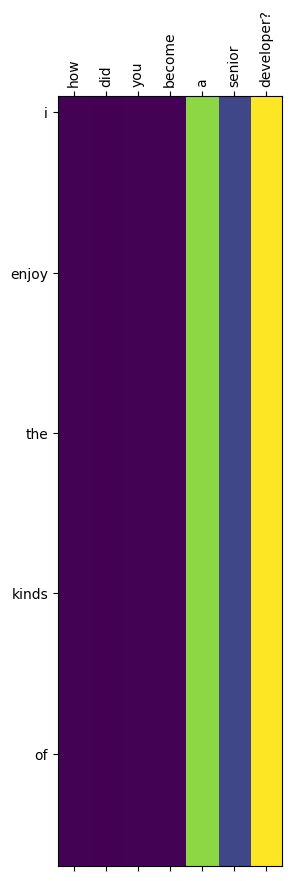

In [ ]:
def evaluate_sentence(sentence):
    attention_plot = np.zeros((max_len_targ, max_len_inp))
    sentence = clean_sentence(sentence)

    inputs = [inp_lang_tokenizer.word_index.get(i, inp_lang_tokenizer.word_index['<unk>']) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_len_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    enc_out, enc_hidden_h, enc_hidden_c = encoder(inputs)
    dec_hidden = enc_hidden_h
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_len_targ):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

max_len_inp = input_tensor.shape[1]
max_len_targ = target_tensor.shape[1]

def plot_attention_map(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    attention = attention[:len(predicted_sentence.split(' ')), :len(sentence.split(' '))]
    ax.matshow(attention, cmap='viridis')

    ax.set_xticklabels([''] + sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + predicted_sentence.split(' '))

    plt.show()

sentence = "how did you become a senior developer?"
result, attention_plot = evaluate_sentence(sentence)
print('Перевод:', result)

import matplotlib.pyplot as plt

plot_attention_map(attention_plot, sentence, result)
